<a href="https://www.kaggle.com/code/clydenarciso/breast-cancer-detection-via-supervised-learning?scriptVersionId=255712157" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Hey there👋 I see you're curious, just like me!**

I'm Clyde Narciso from the University of the Philippines Los Baños. Join me in this journey of problem-solving and potentially life-saving!

In this project, we are given the responsibility of accurately and automatically detecting cancer using machine learning tools!

We have a dataset 'Breast_cancer_dataset.csv' containing features derived from digitized images of fine needle aspirates (FNA) of breast masses, and labels of 'Benign' or 'Malignant'.

Our job is to create a machine learning model that will classify the sample as cancerous or not, given the sample's feature values.

In [1]:
import numpy as np
import pandas as pd 

# Read the dataset into a pandas DataFrame!
df = pd.read_csv('/kaggle/input/breast-cancer-dataset/Breast_cancer_dataset.csv')

In [2]:
# Separate the feature and target variables
columns_to_drop = ['id', 'diagnosis', 'Unnamed: 32']
X = df.drop(columns_to_drop, axis=1)
y = df['diagnosis']

# Convert categorical target variable to binary dummy variables
y_num = pd.get_dummies(y, dtype=int)
# Since a sample can only be either 'B' or 'M' and never both, we can discard a column to reduce dimensionality
y_num = y_num.drop('B', axis=1)

# Convert the DataFrame into a 1D NumPy array
y_num = y_num.values.ravel()

In [3]:
# Import the goodz
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Initializing preprocessing tools
scaler = StandardScaler()

# Splitting the test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y_num, test_size=0.3, stratify=y_num, random_state=1)

# Preprocessing the training and test data
X_train_preprocessed = scaler.fit_transform(X_train)
X_test_preprocessed = scaler.transform(X_test)

In [4]:
# Import some more goodz
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold

# Performing GridSearchCV to optimize the hyperparameter
splits = 5 # this is arbitrarily chosen
kf = KFold(n_splits=splits, shuffle=True, random_state=1)
knn_param_grid = {'n_neighbors': range(1,26)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, knn_param_grid, cv=kf)
knn_cv.fit(X_train_preprocessed, y_train)
print(knn_cv.best_params_, knn_cv.best_score_)

{'n_neighbors': 3} 0.9799367088607595


We choose n_neighbors = 3!

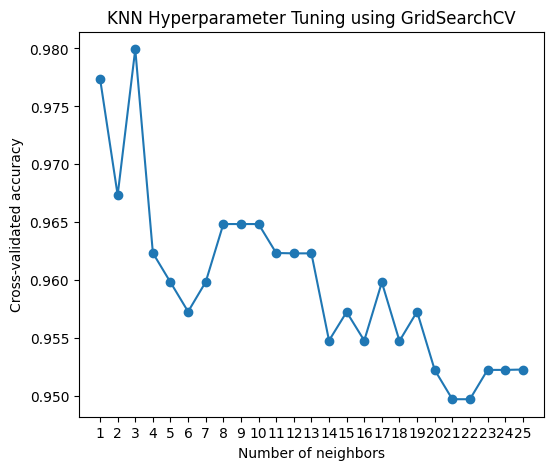

In [5]:
# Visualizing the Hyperparameter Tuning
import matplotlib.pyplot as plt

knn_results_df = knn_cv.cv_results_['mean_test_score']
n_neighbors = knn_param_grid['n_neighbors']

plt.figure(figsize=(6,5))
plt.plot(n_neighbors, knn_results_df, marker='o')
plt.xlabel('Number of neighbors')
plt.ylabel('Cross-validated accuracy')
plt.title('KNN Hyperparameter Tuning using GridSearchCV')
plt.xticks(n_neighbors)
plt.show()

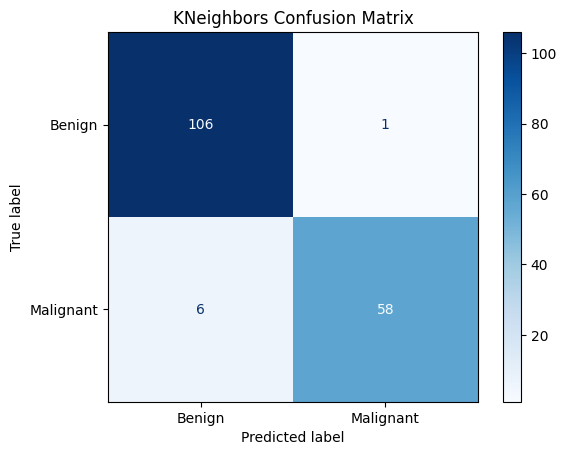

              precision    recall  f1-score   support

           0     0.9464    0.9907    0.9680       107
           1     0.9831    0.9062    0.9431        64

    accuracy                         0.9591       171
   macro avg     0.9647    0.9485    0.9556       171
weighted avg     0.9601    0.9591    0.9587       171



In [6]:
# Construct the confusion matrix and classification report to evaluate our model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

knn_y_pred = knn_cv.predict(X_test_preprocessed)

conf_matrix = confusion_matrix(y_test, knn_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('KNeighbors Confusion Matrix')
plt.show()
print(classification_report(y_test, knn_y_pred, digits=4))

We have 6 cases of False Negatives, meaning our model predicted the tumor was benign, when it was actually malignant. The accuracy is 95.91%.

This is unacceptable! Let's try Logistic Regression this time.

In [7]:
# We will now try Logistic Regression and see if it yields better results
from sklearn.linear_model import LogisticRegression

# Performing GridSearchCV to find optimize the hyperparameters 
# (strength of regularization (C) and regularization techniques (l1 or l2))
lr_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                'penalty': ['l1', 'l2'], 
                'max_iter' : [100, 200, 500, 1000]}
lr = LogisticRegression(solver='liblinear')
lr_cv = GridSearchCV(lr, lr_param_grid, cv=kf)
lr_cv.fit(X_train_preprocessed, y_train)
print(lr_cv.best_params_, lr_cv.best_score_)

{'C': 0.1, 'max_iter': 100, 'penalty': 'l2'} 0.9899683544303798


We choose C = 0.1, and regularization technique = l2 (Ridge regression)!

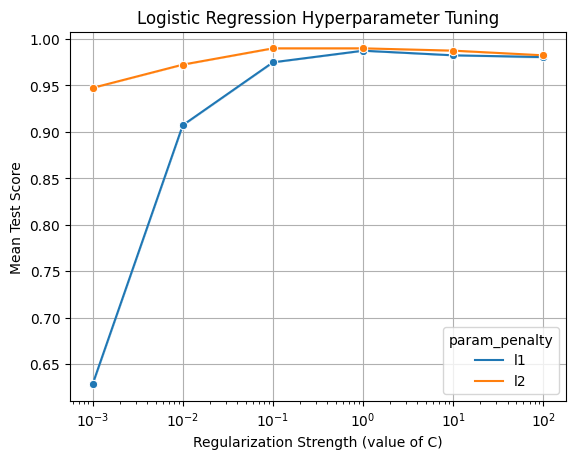

In [8]:
# Visualizing the hyperparameter tuning for Logistic Regression
import seaborn as sns
# Seaborn was giving me FutureWarnings so I'm just doing this as a bandaid solution
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load the results into a DataFrame
lr_results_df = pd.DataFrame(lr_cv.cv_results_)

sns.lineplot(data=lr_results_df, x='param_C', y='mean_test_score', hue='param_penalty', marker='o')
plt.xscale('log')
plt.xlabel('Regularization Strength (value of C)')
plt.ylabel('Mean Test Score')
plt.grid(True)
plt.title('Logistic Regression Hyperparameter Tuning')
plt.show()

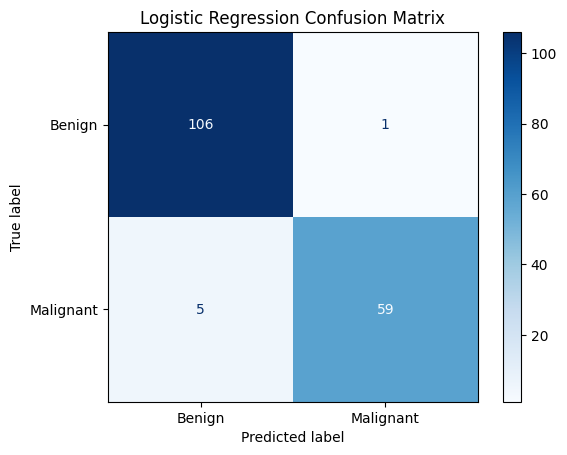

              precision    recall  f1-score   support

           0     0.9550    0.9907    0.9725       107
           1     0.9833    0.9219    0.9516        64

    accuracy                         0.9649       171
   macro avg     0.9691    0.9563    0.9620       171
weighted avg     0.9656    0.9649    0.9647       171



In [9]:
# Now let's use our model with the optimized hyperparameters and analyze the results!
lr_y_pred = lr_cv.predict(X_test_preprocessed)

conf_matrix = confusion_matrix(y_test, lr_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show()
print(classification_report(y_test, lr_y_pred, digits=4))

We have achieved better results with logistic regression compared to k-neighbors classification.

But there are 5 false negatives-- which is a slight improvement! The accuracy is 96.49%.

I wonder-- can we achieve better results? 

I have to study more. Maybe better feature engineering or hyperparameter tuning?

Now, let's try using Linear SVM, and see if it yields better results

In [10]:
from sklearn.svm import LinearSVC
# Instantiate the Linear SVM and perform cross-validation to tune the hyperparameters
linsvm_param_grid = {'C': [0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.1, 1, 2]}
linsvm = LinearSVC()
linsvm_cv = GridSearchCV(linsvm, linsvm_param_grid, cv=kf)
linsvm_cv.fit(X_train_preprocessed, y_train)
print(linsvm_cv.best_params_, linsvm_cv.best_score_)

{'C': 0.008} 0.9899367088607596


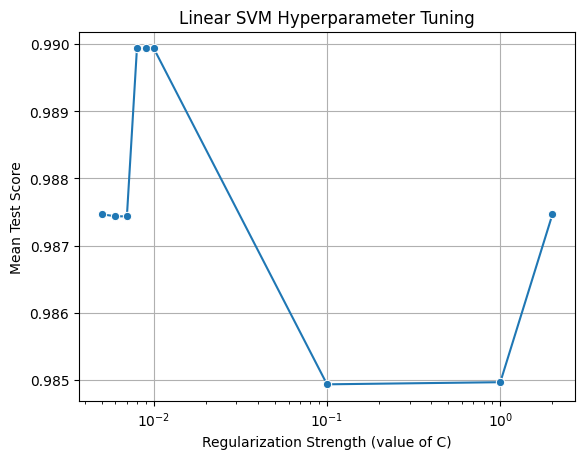

In [11]:
# Load the results into a DataFrame
linsvm_results_df = pd.DataFrame(linsvm_cv.cv_results_)

sns.lineplot(data=linsvm_results_df, x='param_C', y='mean_test_score', marker='o')
plt.xscale('log')
plt.xlabel('Regularization Strength (value of C)')
plt.ylabel('Mean Test Score')
plt.grid(True)
plt.title('Linear SVM Hyperparameter Tuning')
plt.show()

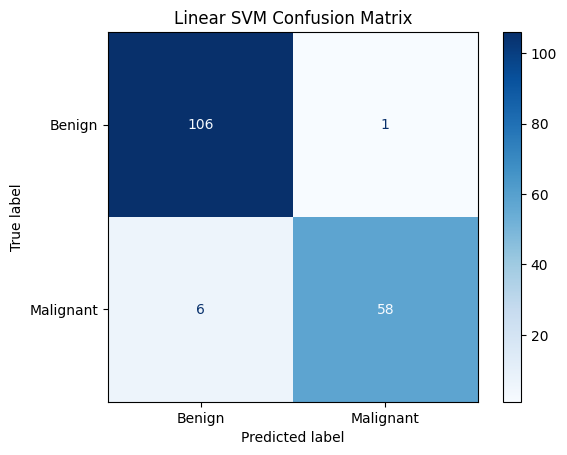

              precision    recall  f1-score   support

           0     0.9464    0.9907    0.9680       107
           1     0.9831    0.9062    0.9431        64

    accuracy                         0.9591       171
   macro avg     0.9647    0.9485    0.9556       171
weighted avg     0.9601    0.9591    0.9587       171



In [12]:
# Now let's use our model with the optimized hyperparameters and analyze the results!
linsvm_y_pred = linsvm_cv.predict(X_test_preprocessed)

conf_matrix = confusion_matrix(y_test, linsvm_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Linear SVM Confusion Matrix')
plt.show()
print(classification_report(y_test, linsvm_y_pred, digits=4))

Now, there are 6 False Negatives. The accuracy is 95.91%.


This is the best we can do so far. I will have to study more to get better results!

Now, let's try the SVM using kernel radial basis function or RBF.

In [13]:
from sklearn.svm import SVC
# Instantiate the SVC and perform cross validation to tune the hyperparameters
svm = SVC()
svm_param_grid = {'C': np.linspace(0.001, 5.0, 50),
                 'gamma': [0.0001, 0.001, 0.01, 0.1, 1]}
svm_cv = GridSearchCV(svm, svm_param_grid, cv=kf)

svm_cv.fit(X_train_preprocessed, y_train)

print(svm_cv.best_params_, svm_cv.best_score_)

{'C': 1.9393877551020404, 'gamma': 0.01} 0.9849367088607595


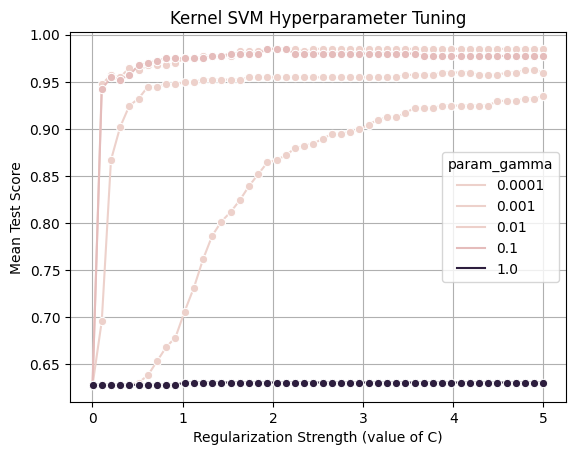

In [14]:
# Visualize hyperparameter tuning
svm_cv_results_df = pd.DataFrame(svm_cv.cv_results_)
sns.lineplot(data=svm_cv_results_df, x='param_C', y='mean_test_score', hue='param_gamma', marker='o')

plt.xlabel('Regularization Strength (value of C)')
plt.ylabel('Mean Test Score')
plt.grid(True)
plt.title('Kernel SVM Hyperparameter Tuning')
plt.show()

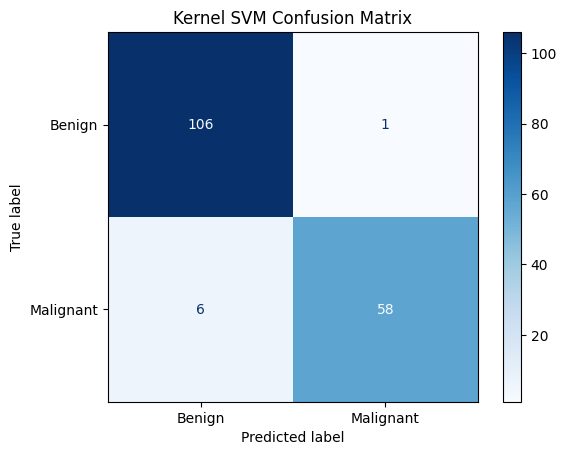

              precision    recall  f1-score   support

           0     0.9464    0.9907    0.9680       107
           1     0.9831    0.9062    0.9431        64

    accuracy                         0.9591       171
   macro avg     0.9647    0.9485    0.9556       171
weighted avg     0.9601    0.9591    0.9587       171



In [15]:
# Now let's use our model with the optimized hyperparameters and analyze the results!
svm_y_pred = svm_cv.predict(X_test_preprocessed)

conf_matrix = confusion_matrix(y_test, svm_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Kernel SVM Confusion Matrix')
plt.show()
print(classification_report(y_test, svm_y_pred, digits=4))

There are 6 False Positives. We can observe that the kernel SVM does not perform better in this case. I wonder if it is the dataset, the model itself, or my modeling that is causing these high errors. The accuracy is 95.91%.

In [16]:
#Instantiate the Decision Tree Classifier and perform cross-validation to tune hyperparameters while avoiding overfitting
from sklearn.tree import DecisionTreeClassifier

dt_param_grid = {'criterion': ['gini', 'entropy'],
                'max_depth': np.arange(1, 21)}
dt = DecisionTreeClassifier()
dt_cv = GridSearchCV(dt, param_grid=dt_param_grid, cv=kf)

dt_cv.fit(X_train_preprocessed, y_train)
print(dt_cv.best_params_, dt_cv.best_score_)


{'criterion': 'gini', 'max_depth': 19} 0.9573101265822785


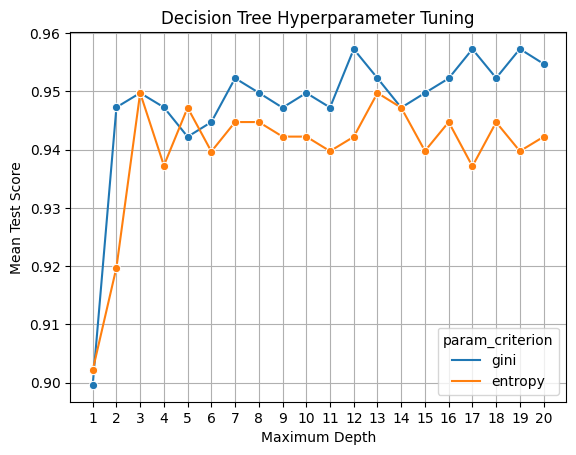

In [17]:
# Visualize hyperparameter tuning of the Decision Tree
dt_cv_results_df = pd.DataFrame(dt_cv.cv_results_)
sns.lineplot(data=dt_cv_results_df, x='param_max_depth', y='mean_test_score', hue='param_criterion', marker='o')

plt.xlabel('Maximum Depth')
plt.xticks(np.arange(1,21))
plt.ylabel('Mean Test Score')
plt.grid(True)
plt.title('Decision Tree Hyperparameter Tuning')
plt.show()

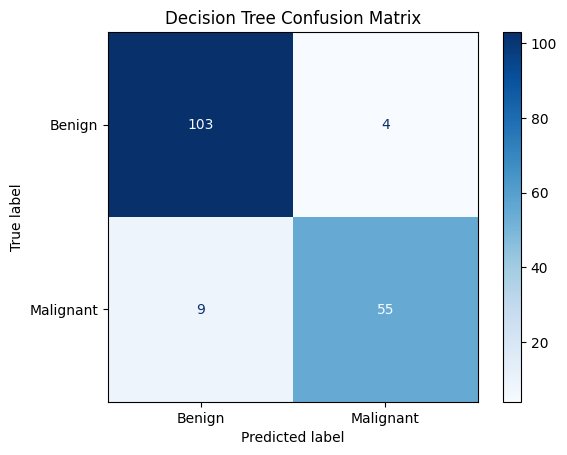

              precision    recall  f1-score   support

           0     0.9196    0.9626    0.9406       107
           1     0.9322    0.8594    0.8943        64

    accuracy                         0.9240       171
   macro avg     0.9259    0.9110    0.9175       171
weighted avg     0.9243    0.9240    0.9233       171



In [18]:
# Now let's use our model with the optimized hyperparameters and analyze the results!
dt_y_pred = dt_cv.predict(X_test_preprocessed)

conf_matrix = confusion_matrix(y_test, dt_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Decision Tree Confusion Matrix')
plt.show()
print(classification_report(y_test, dt_y_pred, digits=4))

The Decision Tree Classifier also does not do so well in this case, resulting in 8 False Negatives. The accuracy is 94.15%. 

In [19]:
# Now let's try Ensemble and combine all our previous models!

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

classifiers = [('KNeighborsClassifier', knn_cv), 
               ('Logistic Regression', lr_cv), 
               ('SVM', svm_cv), 
               ('DecisionTreeClassifier', dt_cv)]

vc = VotingClassifier(estimators=classifiers)

vc.fit(X_train_preprocessed, y_train)

vc_y_pred = vc.predict(X_test_preprocessed)

vc_accuracy = accuracy_score(y_test, vc_y_pred)

print(vc_accuracy)

0.9649122807017544


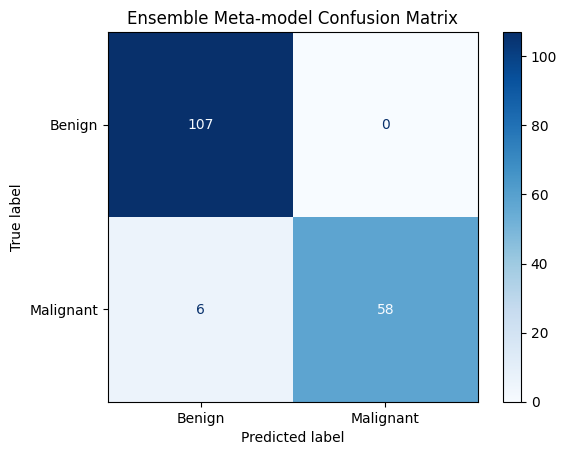

              precision    recall  f1-score   support

           0     0.9469    1.0000    0.9727       107
           1     1.0000    0.9062    0.9508        64

    accuracy                         0.9649       171
   macro avg     0.9735    0.9531    0.9618       171
weighted avg     0.9668    0.9649    0.9645       171



In [20]:
# Visualizing the results

conf_matrix = confusion_matrix(y_test, vc_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Ensemble Meta-model Confusion Matrix')
plt.show()
print(classification_report(y_test, vc_y_pred, digits=4))

The accuracy is 96.49%. We can see that the Ensemble Meta-Model does not perform better in this case.

# Thank you for going on this journey with me! -Clyde